In the data preparation phase of this notebook, I performed several steps to clean and preprocess the dataset, including converting timestamps, handling missing and bad values, and encoding categorical variables. The purpose of this notebook is to build and evaluate regression models to predict delivery duration using the provided dataset. This project aims to analyze and predict DoorDash delivery durations, which can help in optimizing delivery times and improving customer satisfaction.

# Delivery Duration Prediction (Stratascratch)

In [1]:
%pip install category_encoders

from IPython.display import Markdown, display

import pandas as pd
import numpy as np
np.random.seed(42)
rng = np.random.default_rng(42)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from pathlib import Path
data_path = Path('./data')
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


# Load Data

In [2]:
# Load data
df = pd.read_csv(data_path /'historical_data.csv')

In [3]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

# Data Preperation

In [5]:
# Convert timestamps
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

In [6]:
# Create target variable
df['total_delivery_duration_seconds'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()

In [7]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


In [8]:
# Fill missing store_primary_category values with the mode grouped by store_id
df['store_primary_category'] = df.groupby('store_id')['store_primary_category'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown'))


# Check if any store_id has more than one store_primary_category
store_category_counts = df.groupby('store_id')['store_primary_category'].nunique()

# Filter store_ids with more than one unique store_primary_category
store_ids_with_multiple_categories = store_category_counts[store_category_counts > 1].index.tolist()

# For each store_id with multiple categories, replace the less frequent categories with the most frequent one
for store_id in store_ids_with_multiple_categories:
    most_frequent_category = df[df['store_id'] == store_id]['store_primary_category'].mode()[0]
    df.loc[df['store_id'] == store_id, 'store_primary_category'] = most_frequent_category

# Verify the changes
df[['store_id', 'store_primary_category']].drop_duplicates()
        

,store_id,store_primary_category
0,1845,american
1,5477,indian
14,2841,italian
19,4139,mexican
21,5058,italian
...,...,...
197213,1340,italian
197290,6110,italian
197342,215,italian
197347,2956,fast


In [9]:
df['store_primary_category'].isna().sum()

0

In [10]:
# Fill missing values
# Get categorical features with missing values
categorical_features_with_na = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).isnull().any()].tolist()

# Get numeric features with missing values
numeric_features_with_na = df.select_dtypes(include=[np.number]).columns[df.select_dtypes(include=[np.number]).isnull().any()].tolist()

In [11]:
# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=3)

# Impute missing values
df[numeric_features_with_na] = imputer.fit_transform(df[numeric_features_with_na])


# For categorical features, fill missing values with mode
for col in categorical_features_with_na:
    df[col] = df[col].fillna(df[col].mode()[0])

In [12]:
# Drop rows with missing actual_delivery_time
df = df.dropna(subset=['actual_delivery_time'])

# Verify the changes
df.isna().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
total_delivery_duration_seconds                 0
dtype: int64

In [13]:
# Feature Engineering
# Extracting more date and time features
df['created_at_weekday'] = df['created_at'].dt.weekday
df['created_at_weekofyear'] = df['created_at'].dt.isocalendar().week


# Calculate the average item price
df['avg_item_price'] = df['subtotal'] / df['total_items']

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197421 entries, 0 to 197427
Data columns (total 20 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     197421 non-null  float64       
 1   created_at                                    197421 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197421 non-null  int64         
 4   store_primary_category                        197421 non-null  object        
 5   order_protocol                                197421 non-null  float64       
 6   total_items                                   197421 non-null  int64         
 7   subtotal                                      197421 non-null  int64         
 8   num_distinct_items                            197421 non-nu

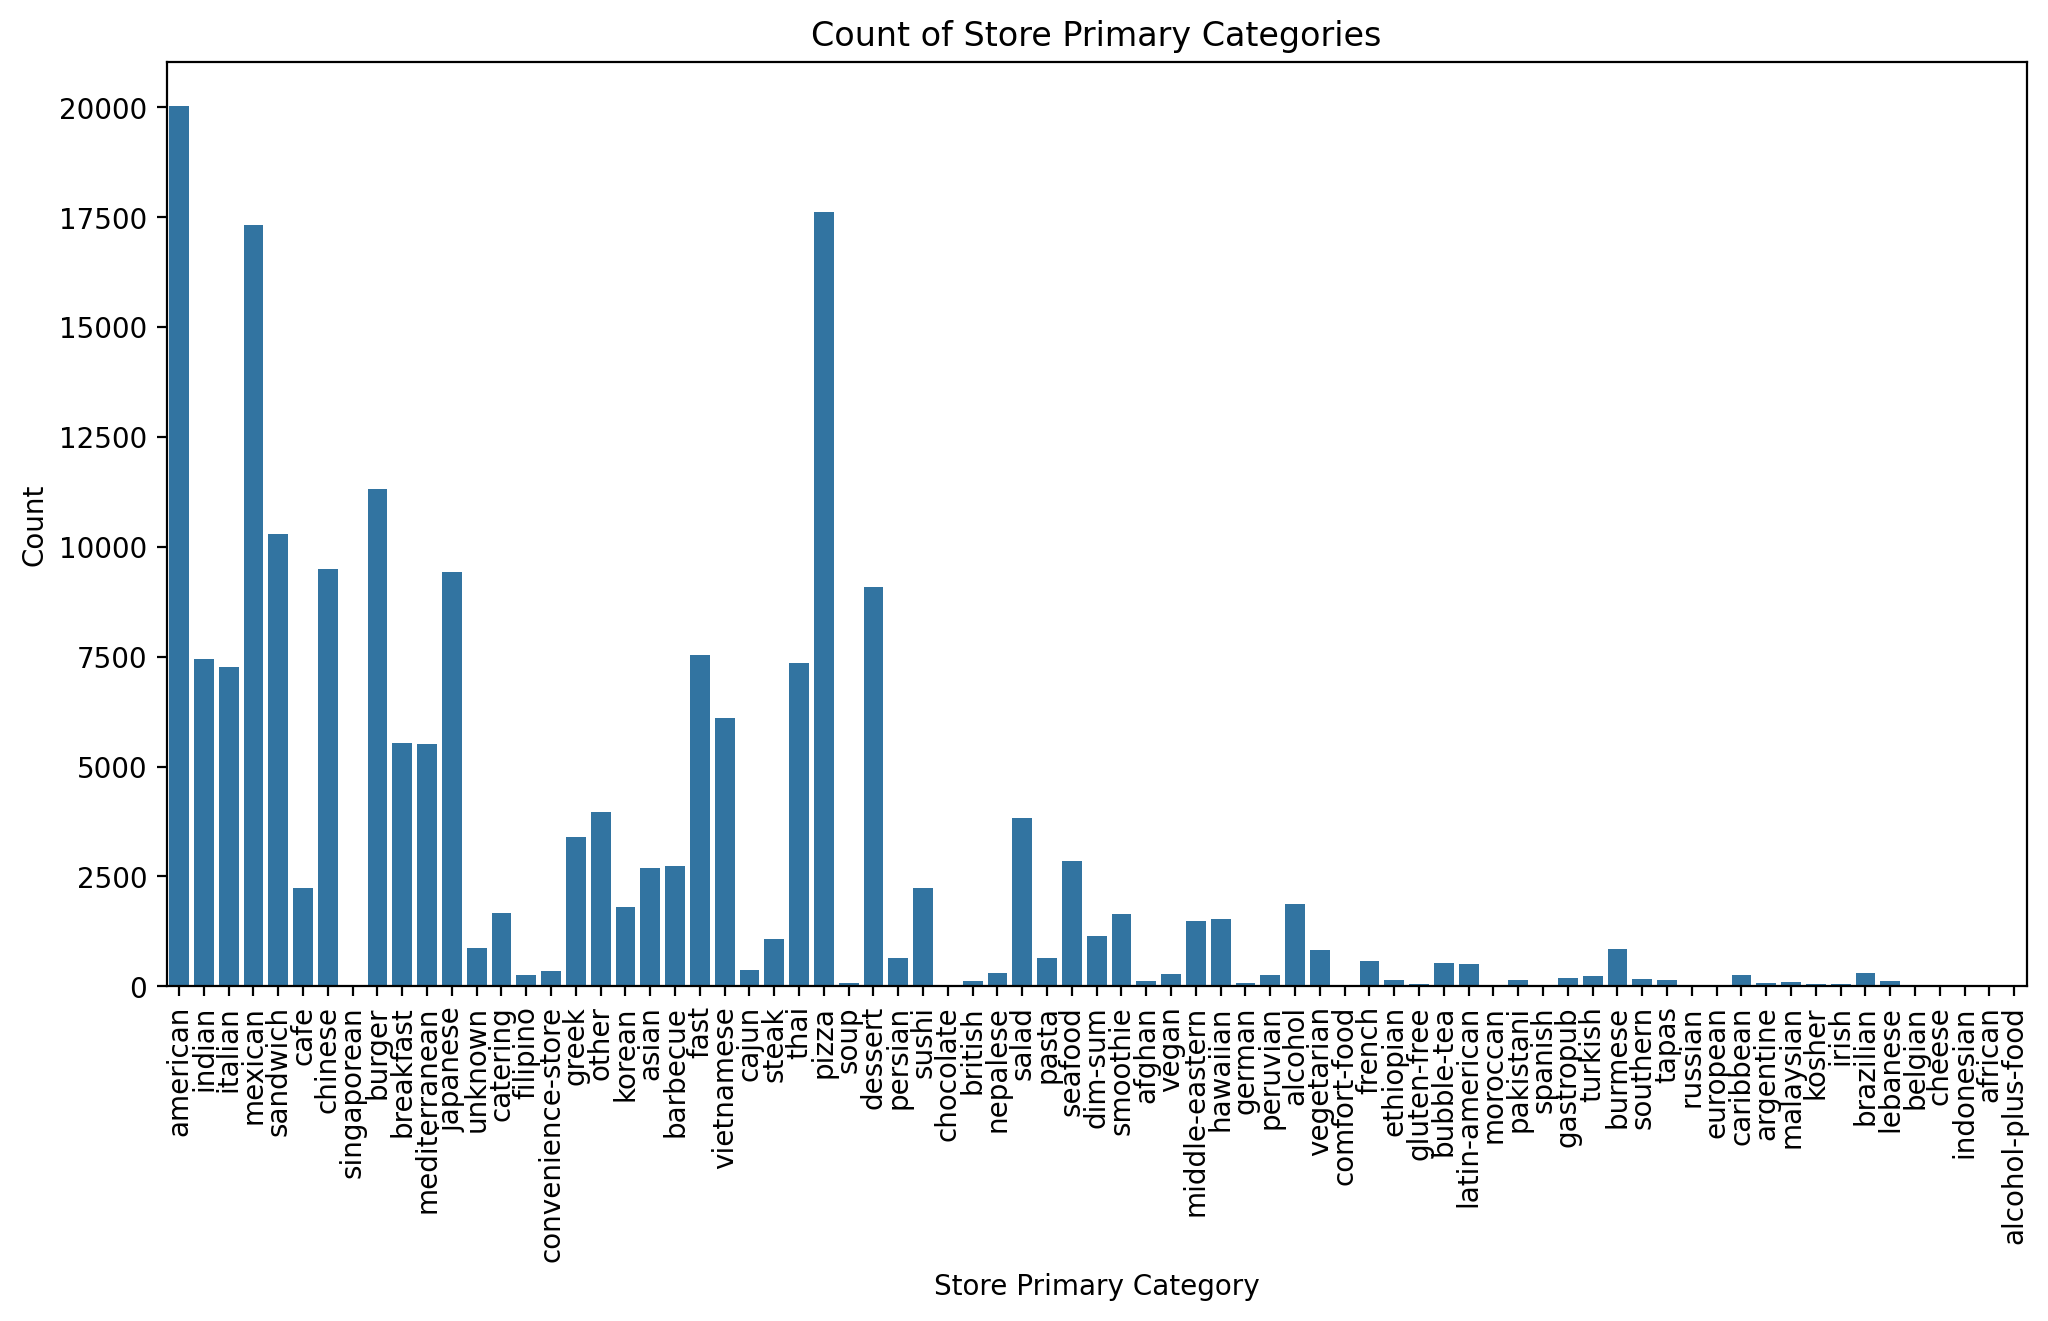

In [15]:
# Count plot of store primary category
plt.figure(figsize=(12, 6))
sns.countplot(x='store_primary_category', data=df)
plt.title('Count of Store Primary Categories')
plt.xlabel('Store Primary Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In this plot, I visualize the distribution of the `store_primary_category` variable. This count plot helps understand the frequency of each category within the dataset. By examining this plot, I can identify which store categories are most common and which are less frequent. This information is useful for understanding the composition of the dataset and can provide insights into the types of stores that are most prevalent in the data. Additionally, it can help in identifying any potential imbalances in the dataset that might need to be addressed during the modeling phase.

### Conclusion from the Graph
- The most common store categories are `american`, `pizza`, `mexican`, `burger`.
- The less frequent store categories include `indonesian`, `alcohol-plus-food`, and `african`, etc.
- There is a noticeable imbalance in the dataset, with certain categories like `american` being significantly more frequent than others. This imbalance might need to be addressed during the modeling phase to ensure that the model does not become biased towards the more frequent categories.

In [16]:
# # Initialize the target encoder
# target_encoder = TargetEncoder()

# # Apply target encoding to the 'store_primary_category' column
# df['store_primary_category'] = target_encoder.fit_transform(df['store_primary_category'], df['total_delivery_duration_seconds'])

# # Display the first few rows of the dataframe with the encoded column
# df.head()

In [19]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest an encoding method
    encoding_method = trial.suggest_categorical('encoding_method', ['onehot', 'ordinal', 'target'])
    
    if encoding_method == 'onehot':
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_features = encoder.fit_transform(df[['store_primary_category']])
    elif encoding_method == 'ordinal':
        encoder = OrdinalEncoder()
        encoded_features = encoder.fit_transform(df[['store_primary_category']])
    elif encoding_method == 'target':
        encoder = TargetEncoder()
        encoded_features = encoder.fit_transform(df['store_primary_category'], df['total_delivery_duration_seconds'])
    
    # Create a new dataframe with the encoded features
    df_encoded = df.copy()
    if encoding_method == 'onehot':
        df_encoded = df_encoded.drop(columns=['store_primary_category'])
        df_encoded = pd.concat([df_encoded, pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['store_primary_category']))], axis=1)
    else:
        df_encoded['store_primary_category'] = encoded_features
    
    # Drop datetime columns
    df_encoded = df_encoded.drop(columns=['created_at', 'actual_delivery_time'])
    
    # Define the model
    model = RandomForestRegressor(random_state=42)
    
    # Perform cross-validation
    scores = cross_val_score(model, df_encoded.drop(columns=['total_delivery_duration_seconds']), df_encoded['total_delivery_duration_seconds'], cv=5, scoring='neg_mean_absolute_error')
    
    # Return the average score
    return scores.mean()

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best encoding method
best_encoding_method = study.best_params['encoding_method']
print(f"The best encoding method is: {best_encoding_method}")

# Apply the best encoding method to the dataframe
if best_encoding_method == 'onehot':
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoded_features = encoder.fit_transform(df[['store_primary_category']])
    df = df.drop(columns=['store_primary_category'])
    df = pd.concat([df, pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['store_primary_category']))], axis=1)
elif best_encoding_method == 'ordinal':
    encoder = OrdinalEncoder()
    df['store_primary_category'] = encoder.fit_transform(df[['store_primary_category']])
elif best_encoding_method == 'target':
    encoder = TargetEncoder()
    df['store_primary_category'] = encoder.fit_transform(df['store_primary_category'], df['total_delivery_duration_seconds'])

# Drop datetime columns
df = df.drop(columns=['created_at', 'actual_delivery_time'])

# Display the first few rows of the dataframe with the encoded column
df.head()

[I 2025-02-28 19:00:24,061] A new study created in memory with name: no-name-f75edaf6-f263-4652-871d-9bfa9ab3af4e
[I 2025-02-28 19:12:17,375] Trial 0 finished with value: -742.5470225279553 and parameters: {'encoding_method': 'ordinal'}. Best is trial 0 with value: -742.5470225279553.
[I 2025-02-28 19:23:53,250] Trial 1 finished with value: -740.9255725386487 and parameters: {'encoding_method': 'target'}. Best is trial 1 with value: -740.9255725386487.
[I 2025-02-28 19:35:37,630] Trial 2 finished with value: -740.9255725386487 and parameters: {'encoding_method': 'target'}. Best is trial 1 with value: -740.9255725386487.
[I 2025-02-28 20:35:23,718] Trial 3 finished with value: -740.9255725386487 and parameters: {'encoding_method': 'target'}. Best is trial 1 with value: -740.9255725386487.
[I 2025-02-28 20:46:58,274] Trial 4 finished with value: -740.9255725386487 and parameters: {'encoding_method': 'target'}. Best is trial 1 with value: -740.9255725386487.
[I 2025-02-28 20:58:32,253] Tr

The best encoding method is: target


,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds,created_at_weekday,created_at_weekofyear,avg_item_price
0,1.0,1845,2870.715556,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,4,6,860.25
1,2.0,5477,2989.596156,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1,7,1900.00
2,3.0,5477,2989.596156,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,3,4,1900.00
3,3.0,5477,2989.596156,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1,6,1150.00
4,3.0,5477,2989.596156,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,6,7,1300.00


### Visualization

#### Univariate Analysis

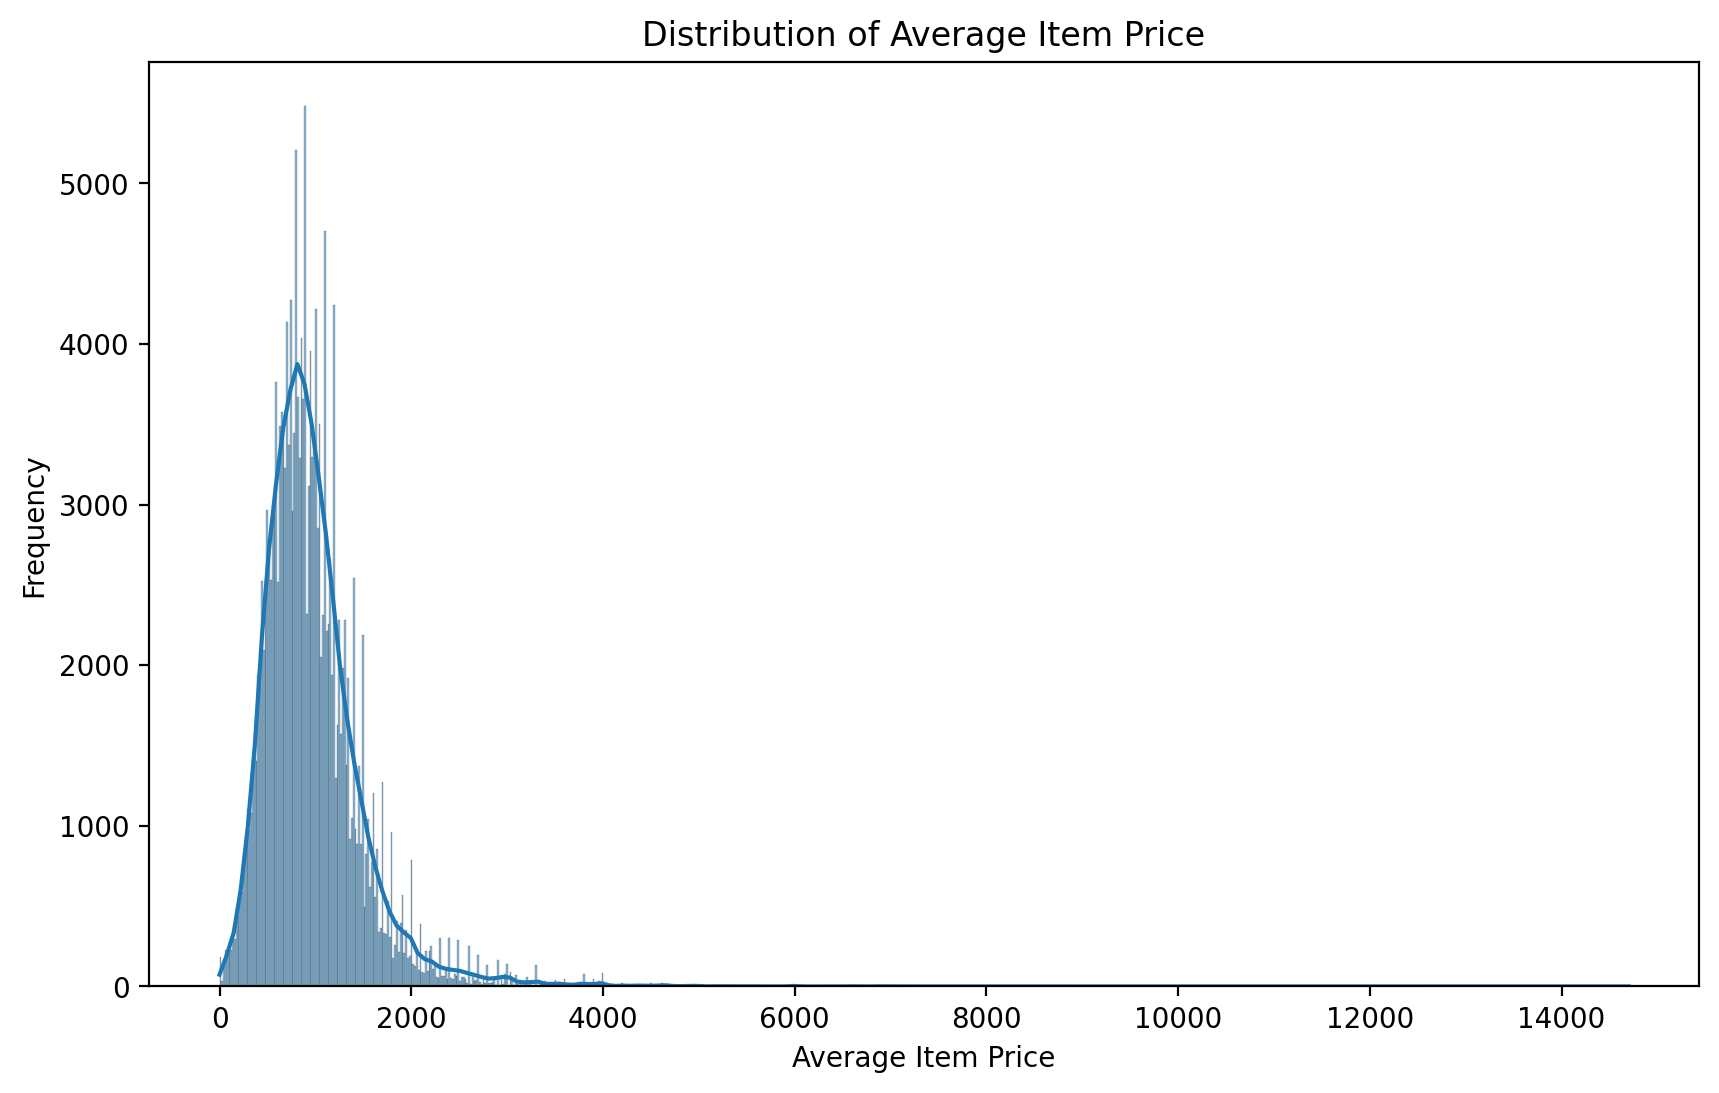

In [ ]:
# Distribution of the average item price
plt.figure(figsize=(10, 6))
sns.histplot(df['avg_item_price'], kde=True)
plt.title('Distribution of Average Item Price')
plt.xlabel('Average Item Price')
plt.ylabel('Frequency')
plt.show()

### Distribution of Average Item Price

The histogram above shows the distribution of the average item price in the dataset. The x-axis represents the average item price, while the y-axis represents the frequency of orders with that average item price.

#### Observations:
- The distribution of the average item price appears to be right-skewed, with a higher frequency of orders having lower average item prices.
- Most orders have an average item price between \$0 and \$1000.
- There are a few orders with very high average item prices, which are considered outliers.

#### Conclusion:
- The majority of orders have a relatively low average item price, indicating that most customers tend to order items that are not very expensive.
- The presence of outliers with high average item prices suggests that there are some orders with premium or high-priced items, but these are not common.
- This skewness in the distribution should be taken into account during the modeling phase, as it may impact the performance of regression models. Transformations or outlier handling techniques might be necessary to improve model accuracy.

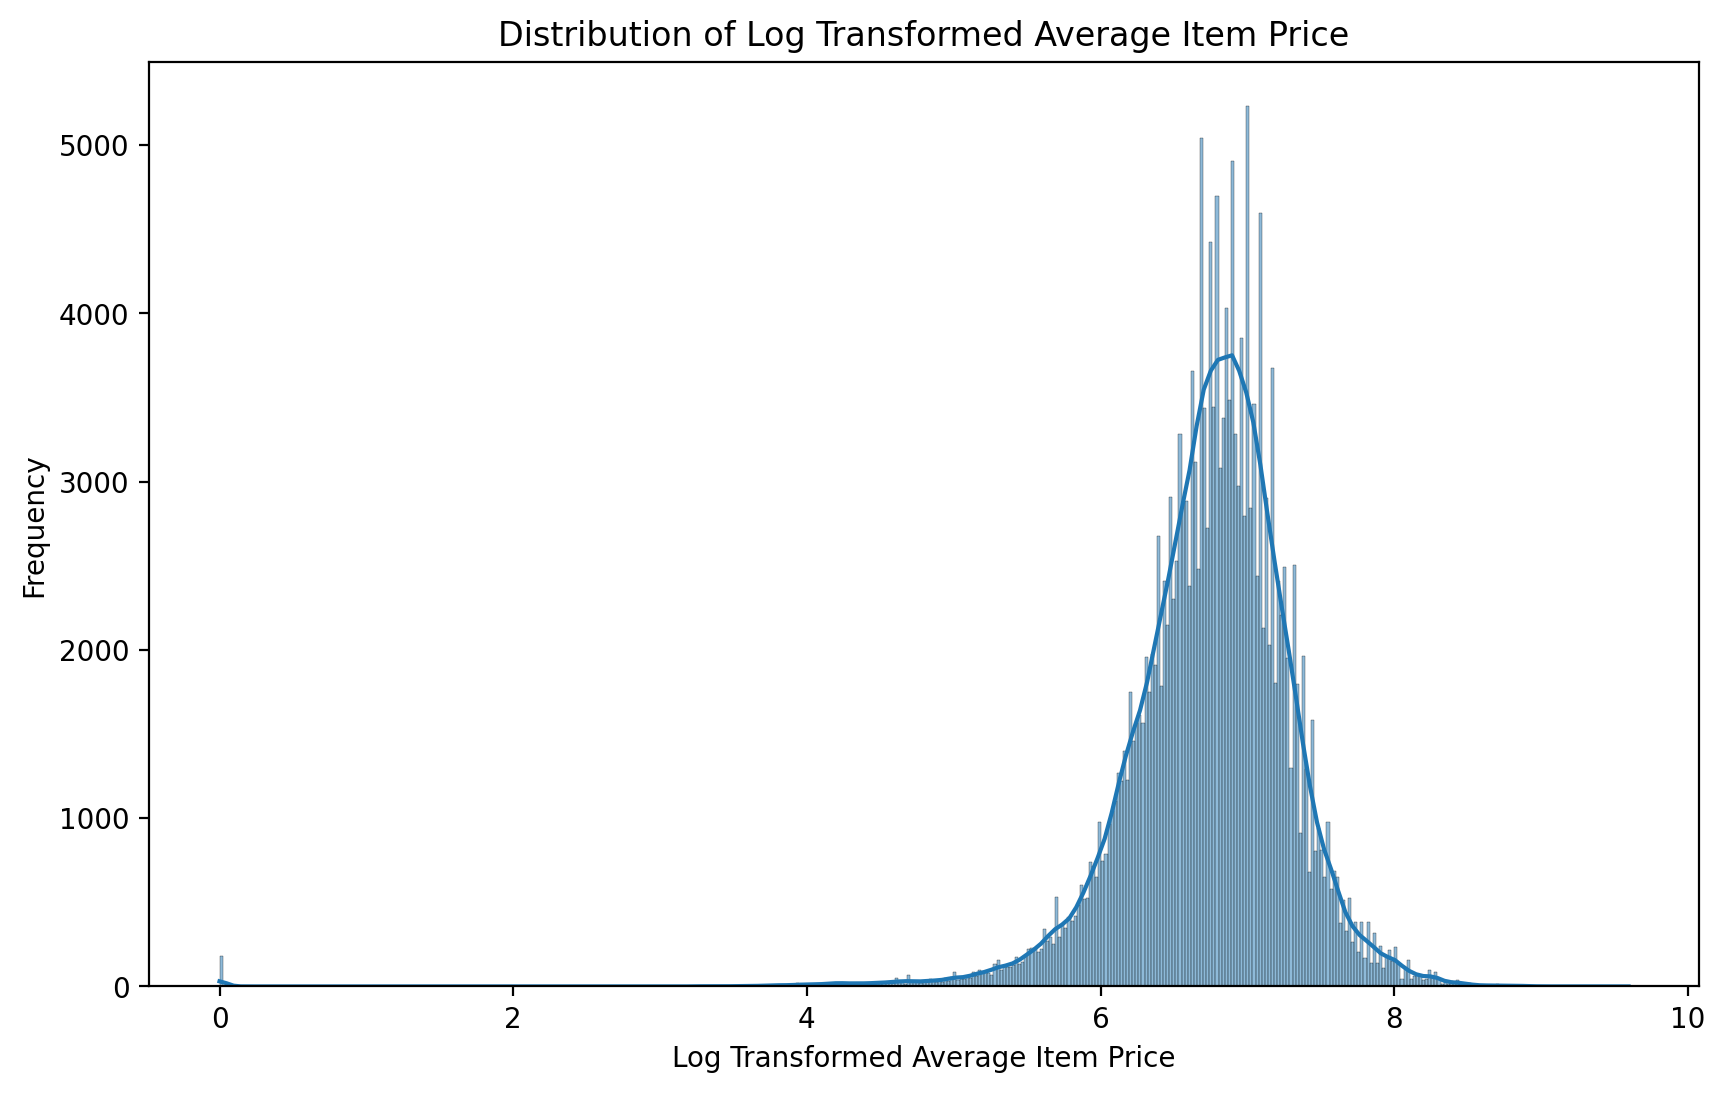

In [ ]:
# Apply logarithmic transformation to avg_item_price
df['log_avg_item_price'] = np.log1p(df['avg_item_price'])

# Plot the distribution of the transformed average item price
plt.figure(figsize=(10, 6))
sns.histplot(df['log_avg_item_price'], kde=True)
plt.title('Distribution of Log Transformed Average Item Price')
plt.xlabel('Log Transformed Average Item Price')
plt.ylabel('Frequency')
plt.show()

### Multivariate analysis


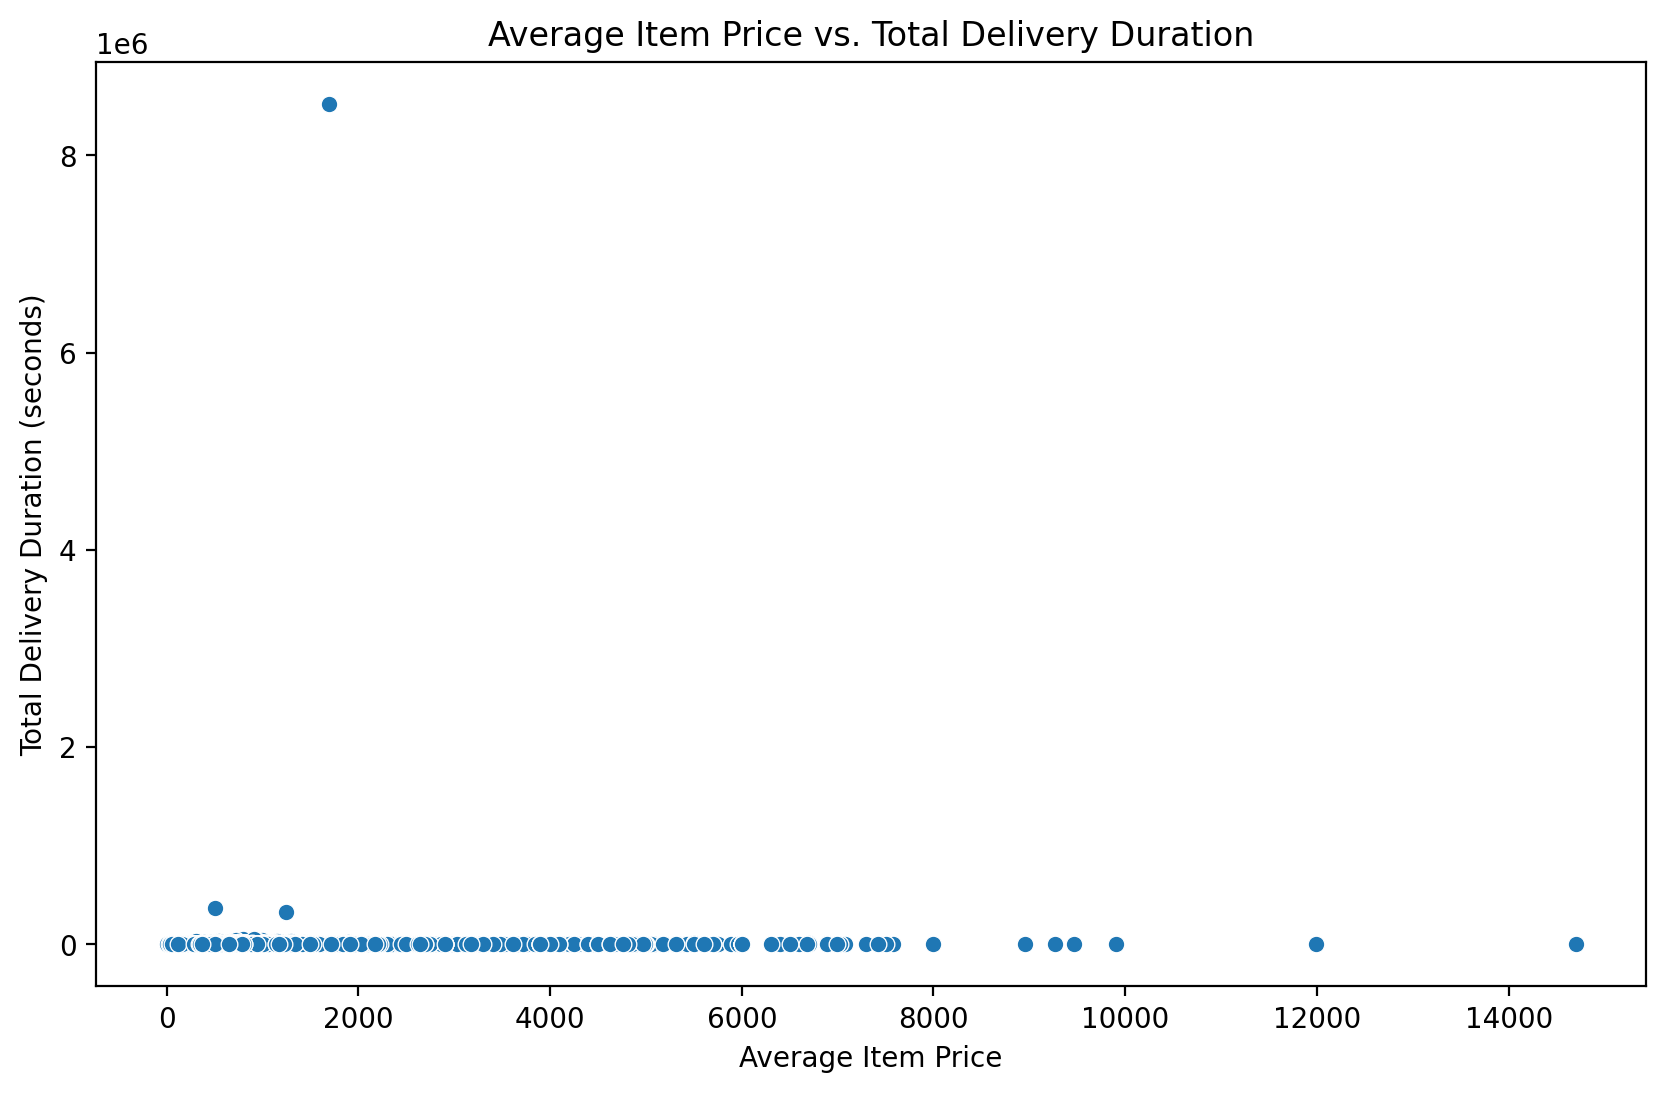

In [ ]:
# Scatter plot of average item price vs. total delivery duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_item_price', y='total_delivery_duration_seconds', data=df)
plt.title('Average Item Price vs. Total Delivery Duration')
plt.xlabel('Average Item Price')
plt.ylabel('Total Delivery Duration (seconds)')
plt.show()

In this scatter plot, I visualize the relationship between the average item price and the total delivery duration. The x-axis represents the average item price, while the y-axis represents the total delivery duration in seconds.

#### Observations:
- There is a wide spread of delivery durations for orders with lower average item prices.
- As the average item price increases, the spread of delivery durations appears to narrow.
- There are some outliers with very high delivery durations, but these are not common.

#### Conclusion:
- The scatter plot suggests that there is no strong linear relationship between the average item price and the total delivery duration.
- Orders with lower average item prices tend to have a more varied range of delivery durations, while orders with higher average item prices tend to have more consistent delivery durations.
- The presence of outliers with high delivery durations indicates that there are some exceptional cases where deliveries took significantly longer than usual. These outliers may need to be investigated further to understand the reasons behind the delays.
- Overall, the average item price does not appear to be a strong predictor of total delivery duration, and other factors may play a more significant role in determining delivery times.

### Check for multicollinearity

In [ ]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds,created_at_weekday,created_at_weekofyear,avg_item_price,log_avg_item_price
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,2870.715556,1.0,4,3441,4,557,...,33.0,14.0,21.0,446,861.0,3779.0,4,6,860.25,6.758385
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,2989.596156,2.0,1,1900,1,1400,...,1.0,2.0,2.0,446,690.0,4024.0,1,7,1900.00,7.550135
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,2989.596156,1.0,1,1900,1,1900,...,1.0,0.0,0.0,446,690.0,1781.0,3,4,1900.00,7.550135
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,2989.596156,1.0,6,6900,5,600,...,1.0,1.0,2.0,446,289.0,3075.0,1,6,1150.00,7.048386
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,2989.596156,1.0,3,3900,3,1100,...,6.0,6.0,9.0,446,650.0,2390.0,6,7,1300.00,7.170888


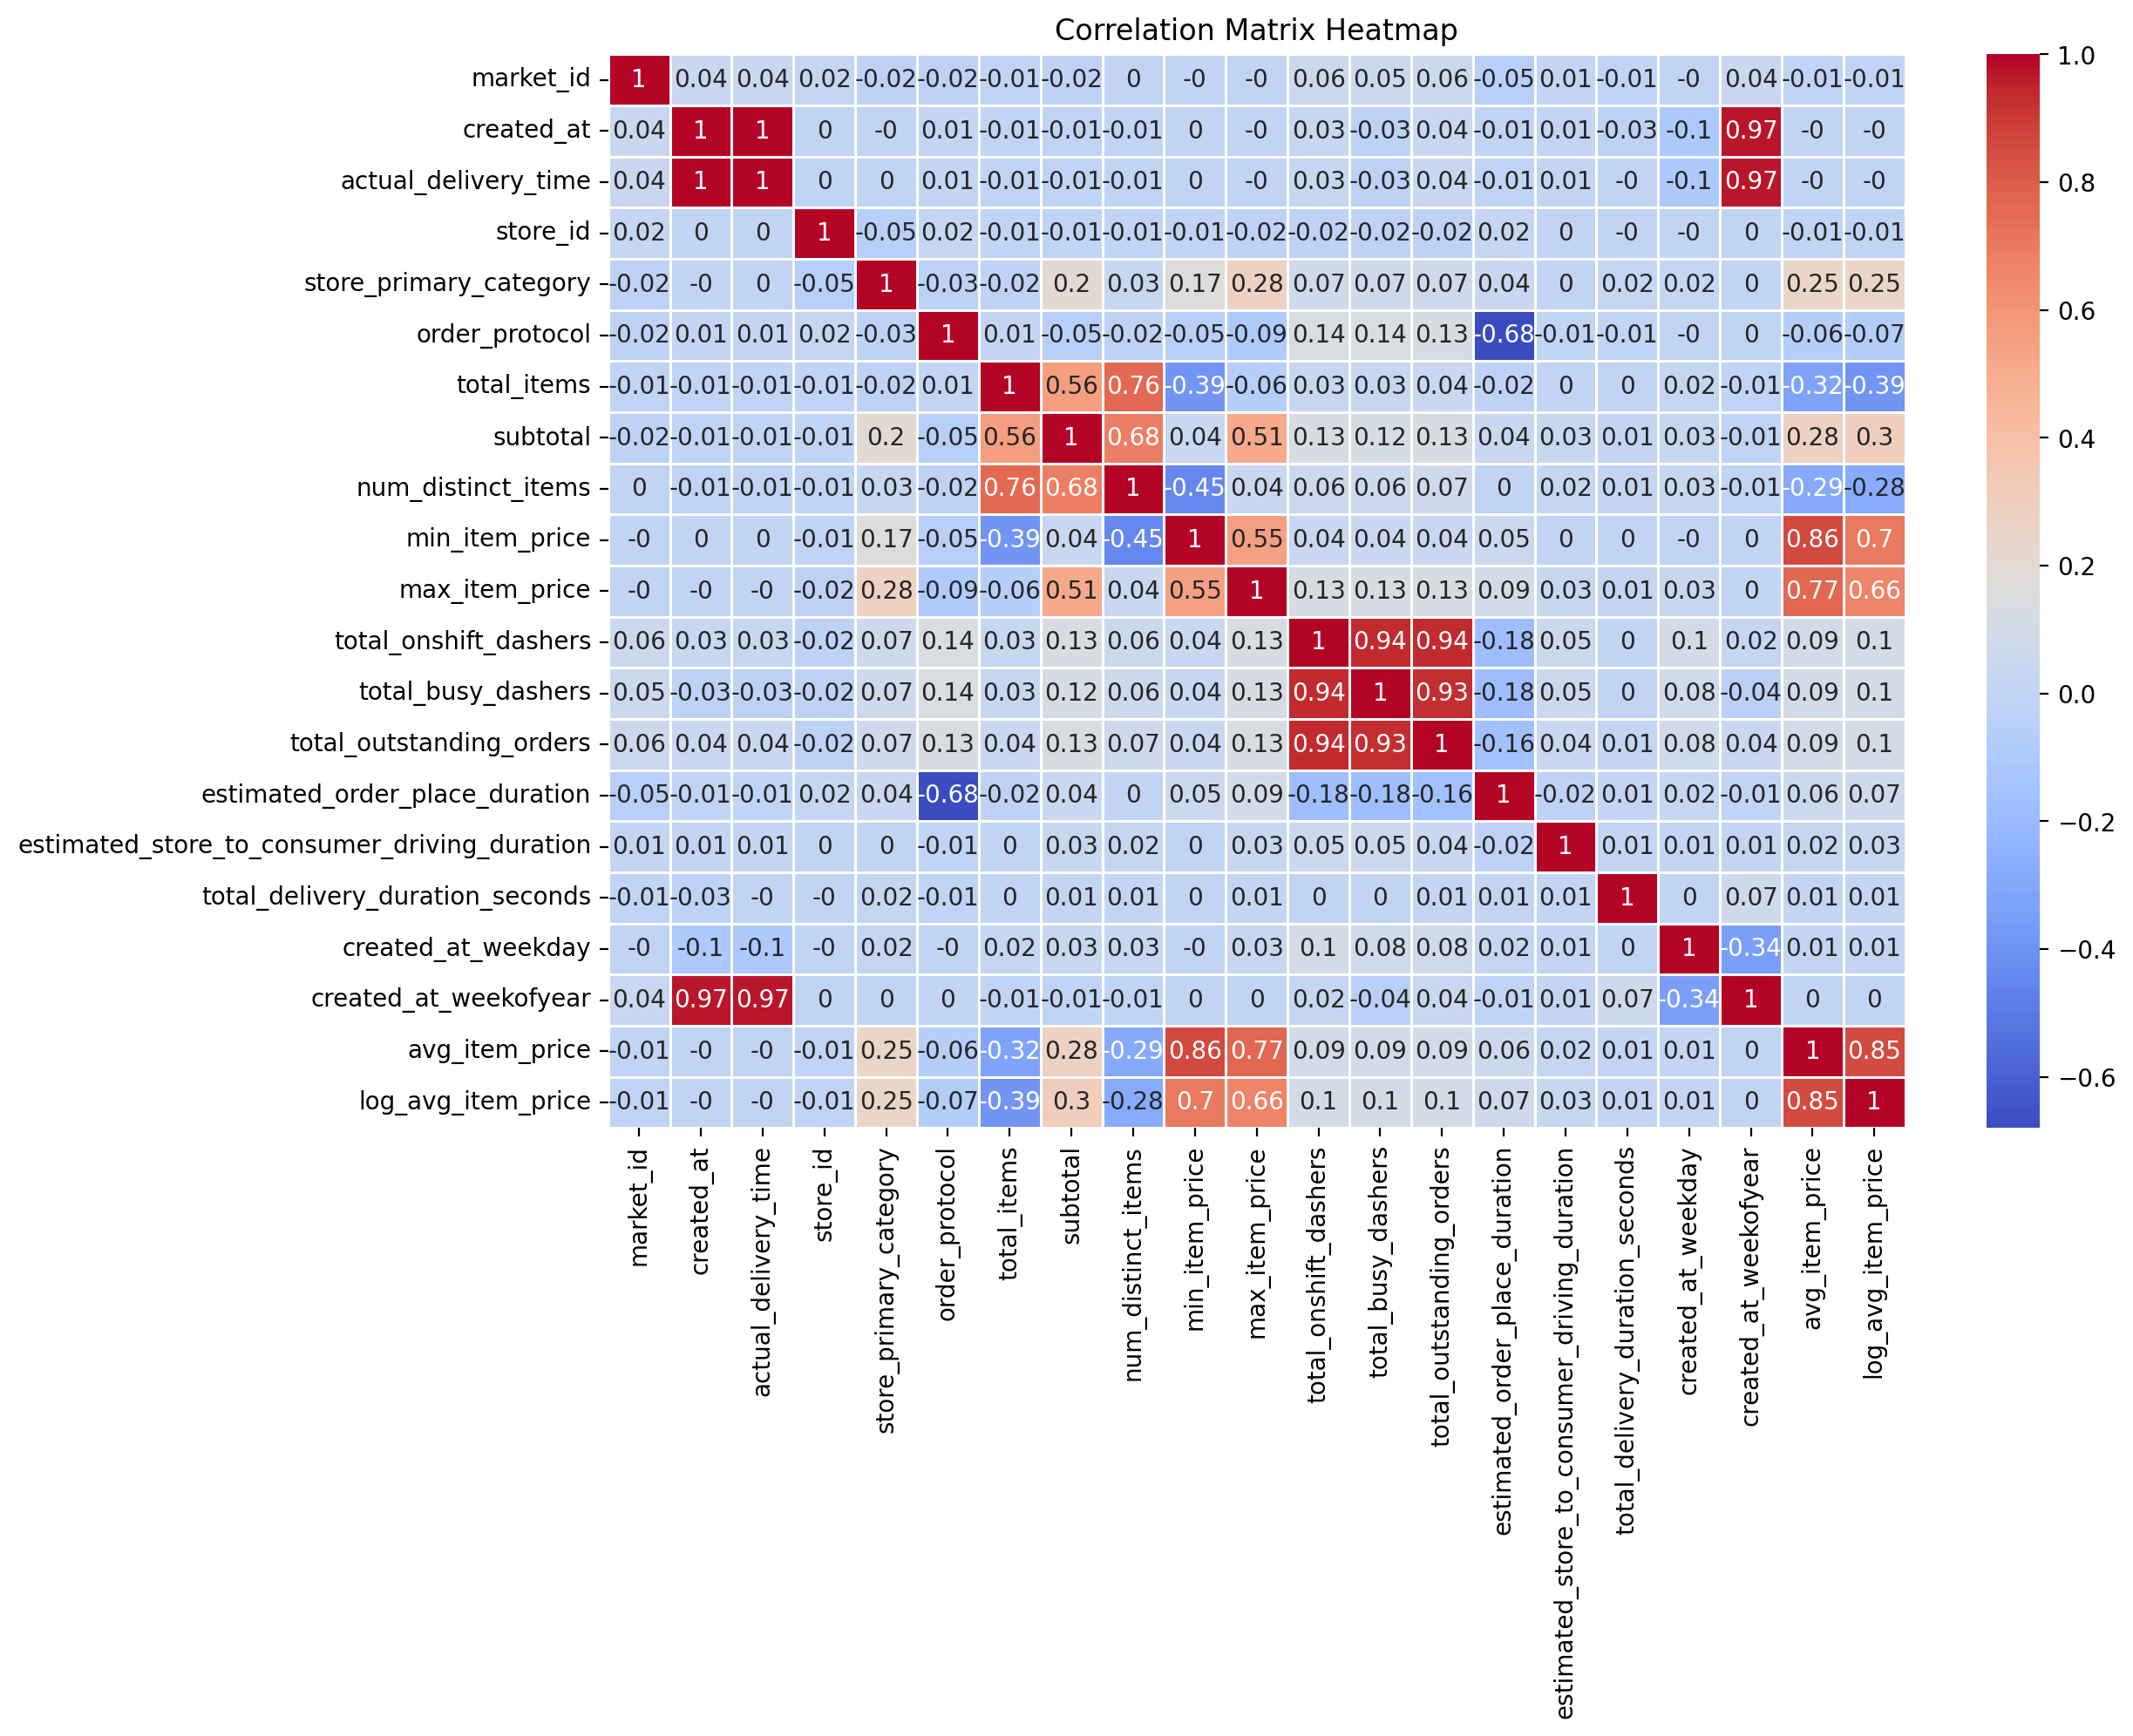

In [ ]:
# Calculate the correlation matrix for all numeric features
corr_matrix = df.corr().round(2)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

The correlation matrix heatmap reveals relationships between variables, with red indicating positive and blue indicating negative correlations.

- The diagonal line shows perfect positive correlation (1) for each variable with itself.
- Variables like `market_id`, `store_id`, `estimated_store_to_consumer_driving_duration`, and `total_delivery_duration_seconds` have low correlation with others.

### High Positive Correlations
- `created_at` and `actual_delivery_time`: 1.00
- `total_onshift_dashers` and `total_busy_dashers`: 0.94
- `total_onshift_dashers` and `total_outstanding_orders`: 0.94
- `total_busy_dashers` and `total_outstanding_orders`: 0.93
- `total_items` and `num_distinct_items`: 0.76
- `min_item_price` and `avg_item_price`: 0.86
- `max_item_price` and `avg_item_price`: 0.77

### High Negative Correlations
- `order_protocol` and `estimated_order_place_duration`: -0.68
- `total_items` and `min_item_price`: -0.39
- `num_distinct_items` and `min_item_price`: -0.45
- `total_items` and `avg_item_price`: -0.32
- `num_distinct_items` and `avg_item_price`: -0.29

To avoid overfitting, we should consider removing one of the highly correlated features from the model.
- Remove either `created_at` or `actual_delivery_time` since they are perfectly correlated.
- Remove either `total_onshift_dashers`, `total_busy_dashers`, or `total_outstanding_orders` as they are highly correlated with each other.
- Remove either `min_item_price` or `max_item_price` since they are strongly correlated with `avg_item_price`.


### Identify and Remove Outliers

In [ ]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, coef=1.5):
        self.coef = coef

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Q1 = X['total_delivery_duration_seconds'].quantile(0.25)
        Q3 = X['total_delivery_duration_seconds'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - self.coef * IQR
        upper_bound = Q3 + self.coef * IQR
        return X[(X['total_delivery_duration_seconds'] >= lower_bound) & (X['total_delivery_duration_seconds'] <= upper_bound)]

# Custom scoring function
def custom_score(X, y=None):
    return X.shape[0]

# Define the parameter grid
param_grid = {'coef': [1.0, 1.5, 2.0, 2.5, 3.0]}

# Initialize the GridSearchCV with custom scoring
grid_search = GridSearchCV(OutlierRemover(), param_grid, cv=5, scoring=make_scorer(custom_score))

# Fit the GridSearchCV
grid_search.fit(df)

# Get the best coefficient
best_coef = grid_search.best_params_['coef']
print(f"The best coefficient is: {best_coef}")

# Apply the best coefficient to remove outliers
outlier_remover = OutlierRemover(coef=best_coef)
df_no_outliers = outlier_remover.transform(df)

The best coefficient is: 1.0


In [ ]:
df_no_outliers

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds,created_at_weekday,created_at_weekofyear,avg_item_price,log_avg_item_price
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,2870.715556,1.0,4,3441,4,557,...,33.0,14.0,21.0,446,861.0,3779.0,4,6,860.250000,6.758385
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,2989.596156,2.0,1,1900,1,1400,...,1.0,2.0,2.0,446,690.0,4024.0,1,7,1900.000000,7.550135
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,2989.596156,1.0,1,1900,1,1900,...,1.0,0.0,0.0,446,690.0,1781.0,3,4,1900.000000,7.550135
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,2989.596156,1.0,6,6900,5,600,...,1.0,1.0,2.0,446,289.0,3075.0,1,6,1150.000000,7.048386
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,2989.596156,1.0,3,3900,3,1100,...,6.0,6.0,9.0,446,650.0,2390.0,6,7,1300.000000,7.170888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,2956,2626.125166,4.0,3,1389,3,345,...,17.0,17.0,23.0,251,331.0,3907.0,1,8,463.000000,6.139885
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,2956,2626.125166,4.0,6,3010,4,405,...,12.0,11.0,14.0,251,915.0,3383.0,4,7,501.666667,6.219927
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,2956,2626.125166,4.0,5,1836,3,300,...,39.0,41.0,40.0,251,795.0,3008.0,5,4,367.200000,5.908626
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,3630,2677.141038,1.0,1,1175,1,535,...,7.0,7.0,12.0,446,384.0,3907.0,6,5,1175.000000,7.069874


In [ ]:
# Save Cleaned Data
df_no_outliers.to_csv(data_path / 'cleaned_historical_data.csv', index=False)